In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

MAX_MEMORY = '4G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'Sept_20_analysis.csv'
df = spark.read.option("header", "true").csv(filename_data, mode="DROPMALFORMED")
df = df.withColumn("BlackElo",df.BlackElo.cast(IntegerType())) \
    .withColumn("WhiteElo",df.WhiteElo.cast(IntegerType())) \
    .withColumn("Total_moves",df.Total_moves.cast(IntegerType())) \
    .withColumn("Game_flips",df.Game_flips.cast(IntegerType())) \
    .drop("Date", "ECO", "Site", "UTCTime", "Black_ts_moves", "White_ts_moves", "Black_ts_blunders", "White_ts_blunders", "Black_ts_mistakes", "White_ts_mistake", "Black_long_moves", "White_long_moves", "Black_bad_long_moves", "White_bad_long_moves", "Game_flips_ts", "Black_blunders", "White_blunders", "Black_mistakes", "White_mistakes", "Black_inaccuracies", "White_inaccuracies", "starting_time", "increment", "White_inferior_moves", "Black_inferior_moves", "increment", "starting_time", "WhiteRatingDiff", "BlackRatingDiff", "TimeControl", "White_elo_category", "Black_elo_category", "Event")

print('Data overview')
df.printSchema()

total_games_count = df.count()
total_games_count

Data overview
root
 |-- GAME: string (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Game_flips: integer (nullable = true)



3739909

# Вывод пропущенных значений

In [3]:
string_columns = ['Opening', 'Termination', 'Game_type','Result', 'GAME']
numeric_columns = ['BlackElo', 'WhiteElo', 'Total_moves', 'Game_flips']

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([0,None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,GAME,BlackElo,Opening,Result,Termination,WhiteElo,Game_type,Total_moves,Game_flips
0,0,0,0,0,0,0,0,0,58686


# Устранение пропущенных значений

In [4]:
df = df.withColumn('Game_flips', 
                   when(col('Game_flips').isin([0,None,np.nan]) | col('Game_flips').isNull(),
                        None).otherwise(col('Game_flips')))
df = df.dropna(subset=['Game_flips'])
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,GAME,BlackElo,Opening,Result,Termination,WhiteElo,Game_type,Total_moves,Game_flips
0,0,0,0,0,0,0,0,0,0


In [5]:
'Data frame describe (numeric columns only):'
df.select(df.BlackElo, df.WhiteElo, df.Total_moves, df.Game_flips).describe().toPandas()

'Data frame describe (numeric columns only):'

,summary,BlackElo,WhiteElo,Total_moves,Game_flips
0,count,3681223,3681223,3681223,3681223
1,mean,1600.2542394198883,1599.4353640081029,64.22329752910922,6.351578537893521
2,stddev,343.0270447467863,343.00899274862326,26.701266729246107,4.710643590221435
3,min,600,600,5,1
4,max,3957,3958,336,83


# Устранение выбросов с помощью межквартильного диапазона

In [6]:
for column in ['BlackElo', 'WhiteElo', 'Total_moves', 'Game_flips']:

    # Q1 : First Quartile ., Q3 : Third Quartile
    Q1 = df.approxQuantile(column,[0.25],relativeError=0)
    Q3 = df.approxQuantile(column,[0.75],relativeError=0)
    # IQR : Inter Quantile Range
    # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
    # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
    IQR = Q3[0] - Q1[0]
        
    #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
    less_Q1 =  Q1[0] - 1.5*IQR
    more_Q3 =  Q3[0] + 1.5*IQR
           
    df = df.filter((df[column] < more_Q3) & (df[column] > less_Q1))  

df.select(df.BlackElo, df.WhiteElo, df.Total_moves, df.Game_flips).describe().toPandas()

,summary,BlackElo,WhiteElo,Total_moves,Game_flips
0,count,3439451,3439451,3439451,3439451
1,mean,1592.1780063155427,1591.419587893533,60.4922334988927,5.818854520677864
2,stddev,335.91978584625105,335.93962700053197,21.34167806780804,3.936195758146635
3,min,624,626,5,1
4,max,2566,2560,123,17


# Определение трех самых популярных типов игры

Top 3  games types:


/tmp/ipykernel_4074/3183535642.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_games_type_df['Game_type'],


,Game_type,count,percentage
0,Blitz,1655951,44.277842
1,Rapid,883537,23.624559
2,Bullet,758876,20.291296
0,others,441545,11.806303


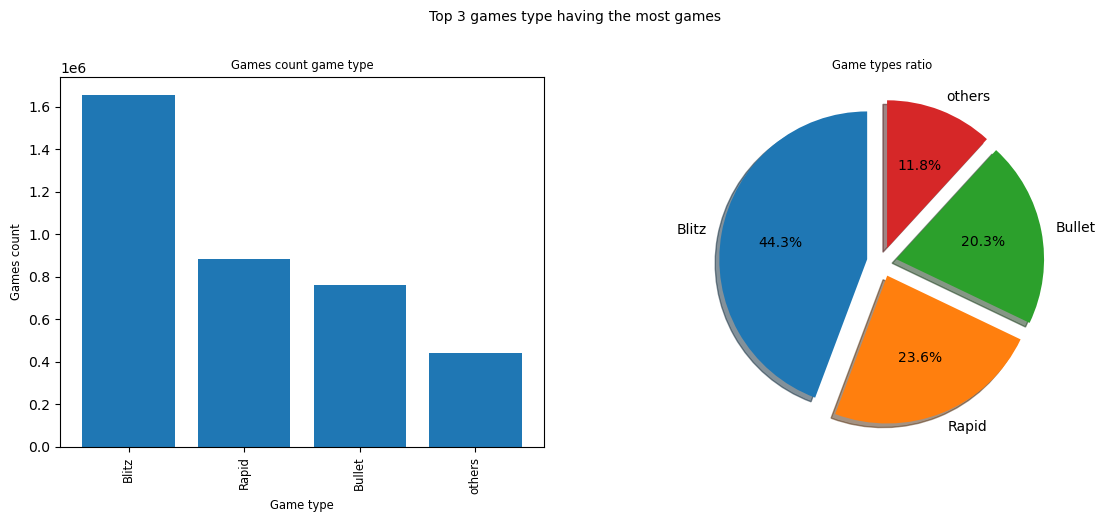

In [7]:
highest_games_type_df = df.select(df.Game_type, df.GAME) \
    .groupBy(df.Game_type) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(3) \
    .toPandas()


highest_games_type_df['percentage'] = highest_games_type_df['count'] \
    / total_games_count * 100

others = {
    'Game_type': 'others', 
    'count':total_games_count - np.sum(highest_games_type_df['count']), 
    'percentage': 100 - np.sum(highest_games_type_df['percentage'])
}

highest_games_type_df = pd.concat([highest_games_type_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_games_type_df['Game_type'], 
                     height=highest_games_type_df['count'])
title0 =  axs[0].set_title('Games count game type', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Game type', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Games count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_games_type_df['Game_type'],
                                       rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.1, 0.1)
title1 = axs[1].set_title('Game types ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=highest_games_type_df['percentage'],
    labels=highest_games_type_df['Game_type'], 
    autopct='%1.1f%%', 
    shadow=True, 
    explode=explode, 
    startangle=90, 
    radius=1
)

print('Top 3  games types:')
highest_games_type_df


text = fig.text(0.5, 1.02, 'Top 3 games type having the most games', ha='center', va='top', transform=fig.transFigure)

# Распределение причин окончания игры в зависимости от типа игры

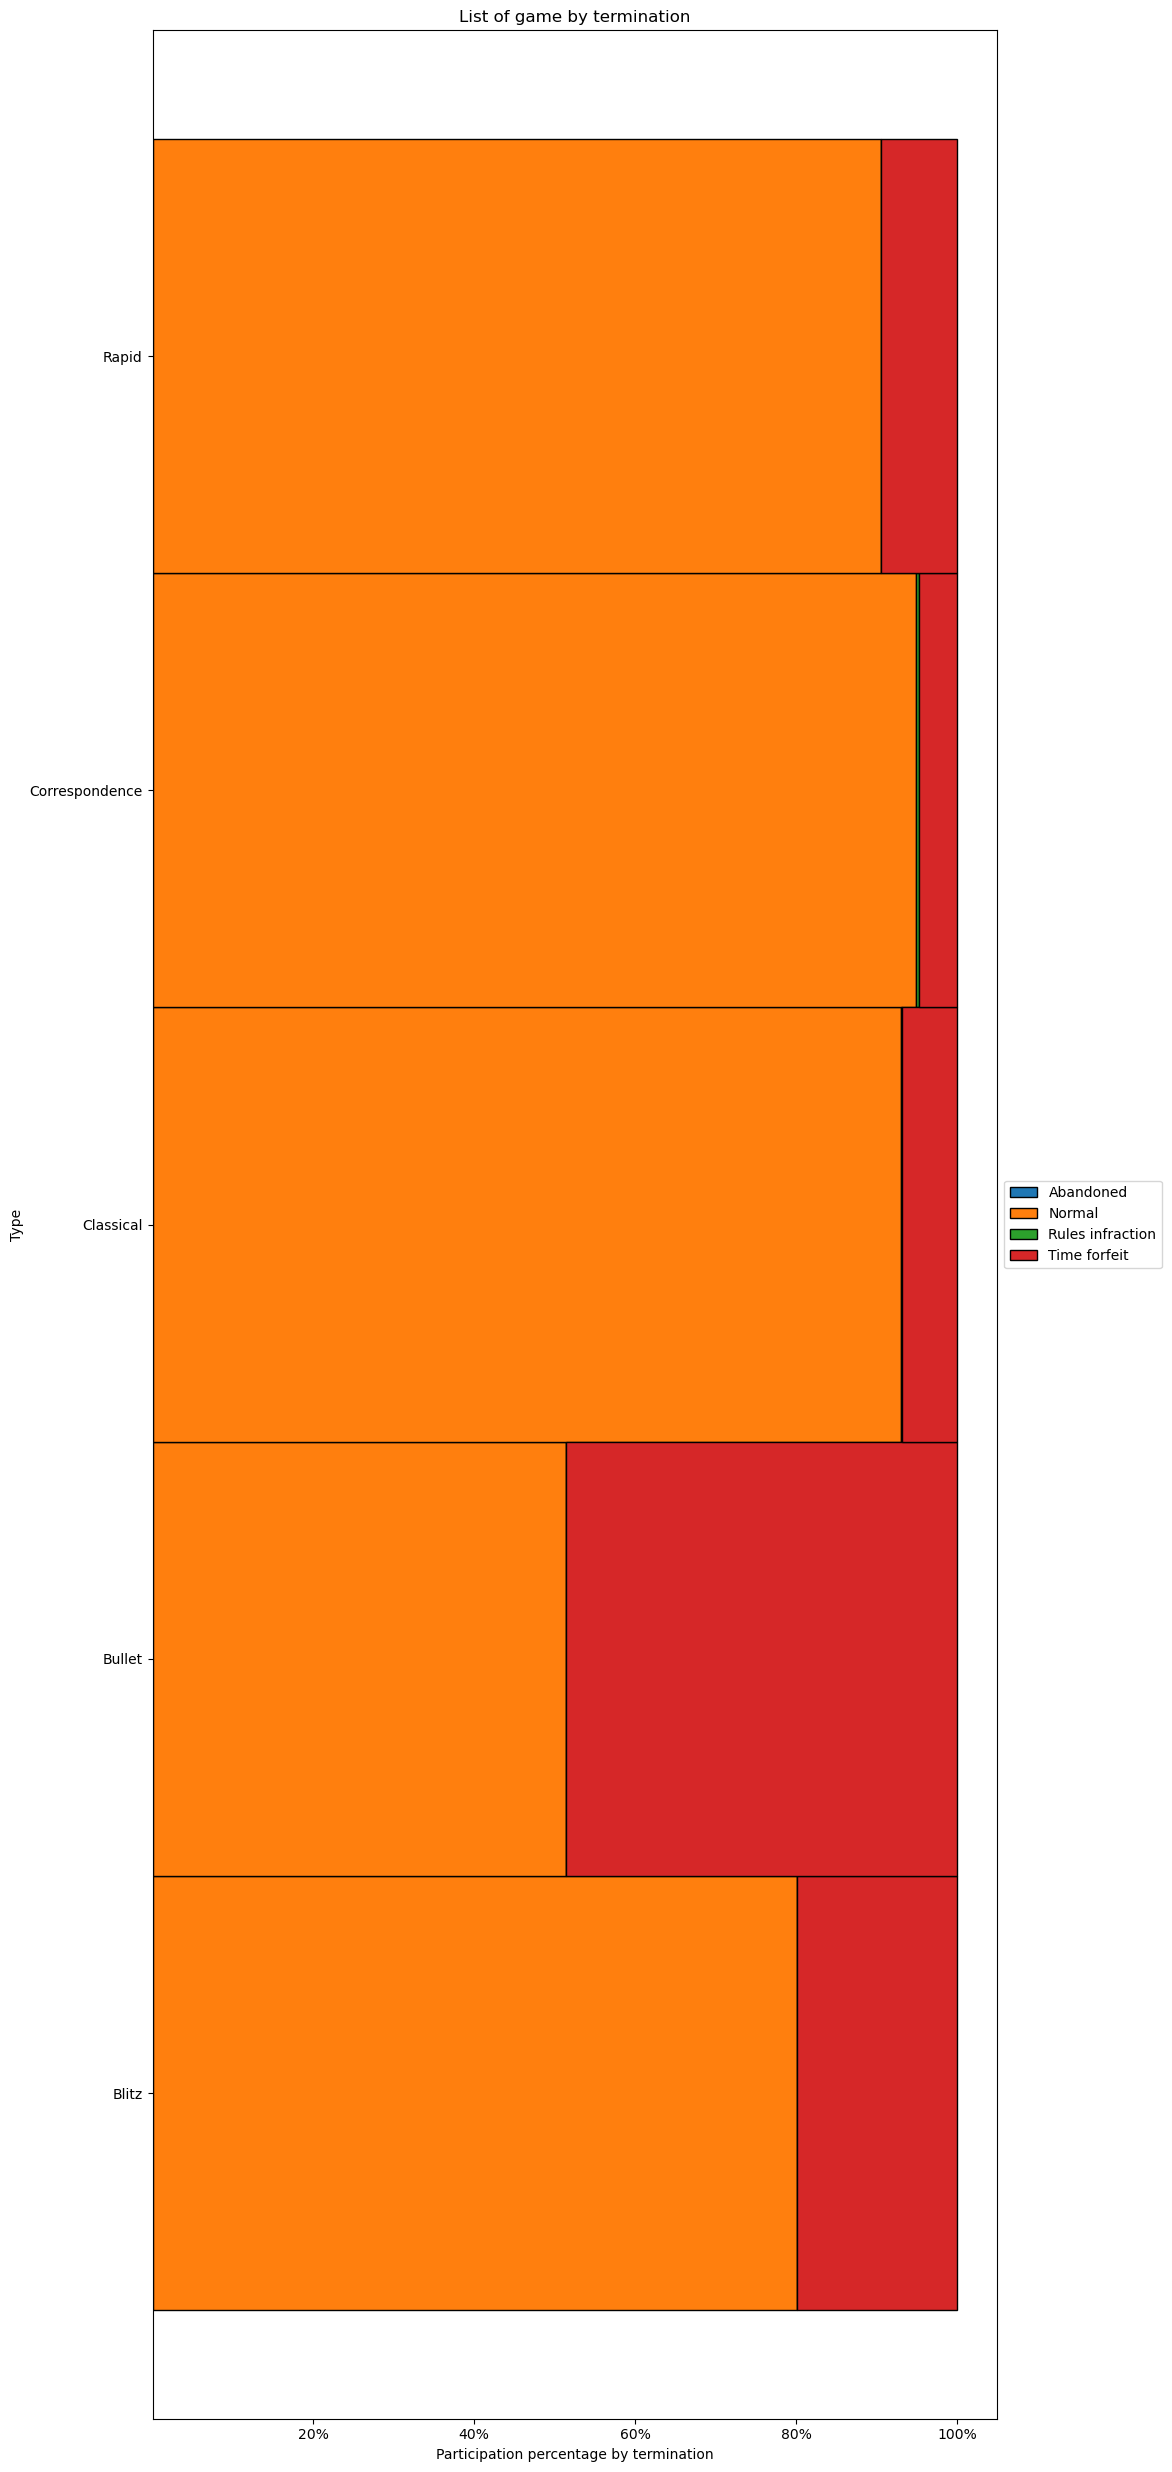

In [8]:
game_by_termination_df = df.groupBy(df.Game_type, df.Termination).count().toPandas()

terminations = game_by_termination_df['Termination'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = game_by_termination_df.groupby(['Game_type', 'Termination'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of game by termination')
ylabel = plt.ylabel('Type');
xlabel = plt.xlabel('Participation percentage by termination');
legend = plt.legend(
    sorted(terminations), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

# Распределение результатов в зависимости от типа игры

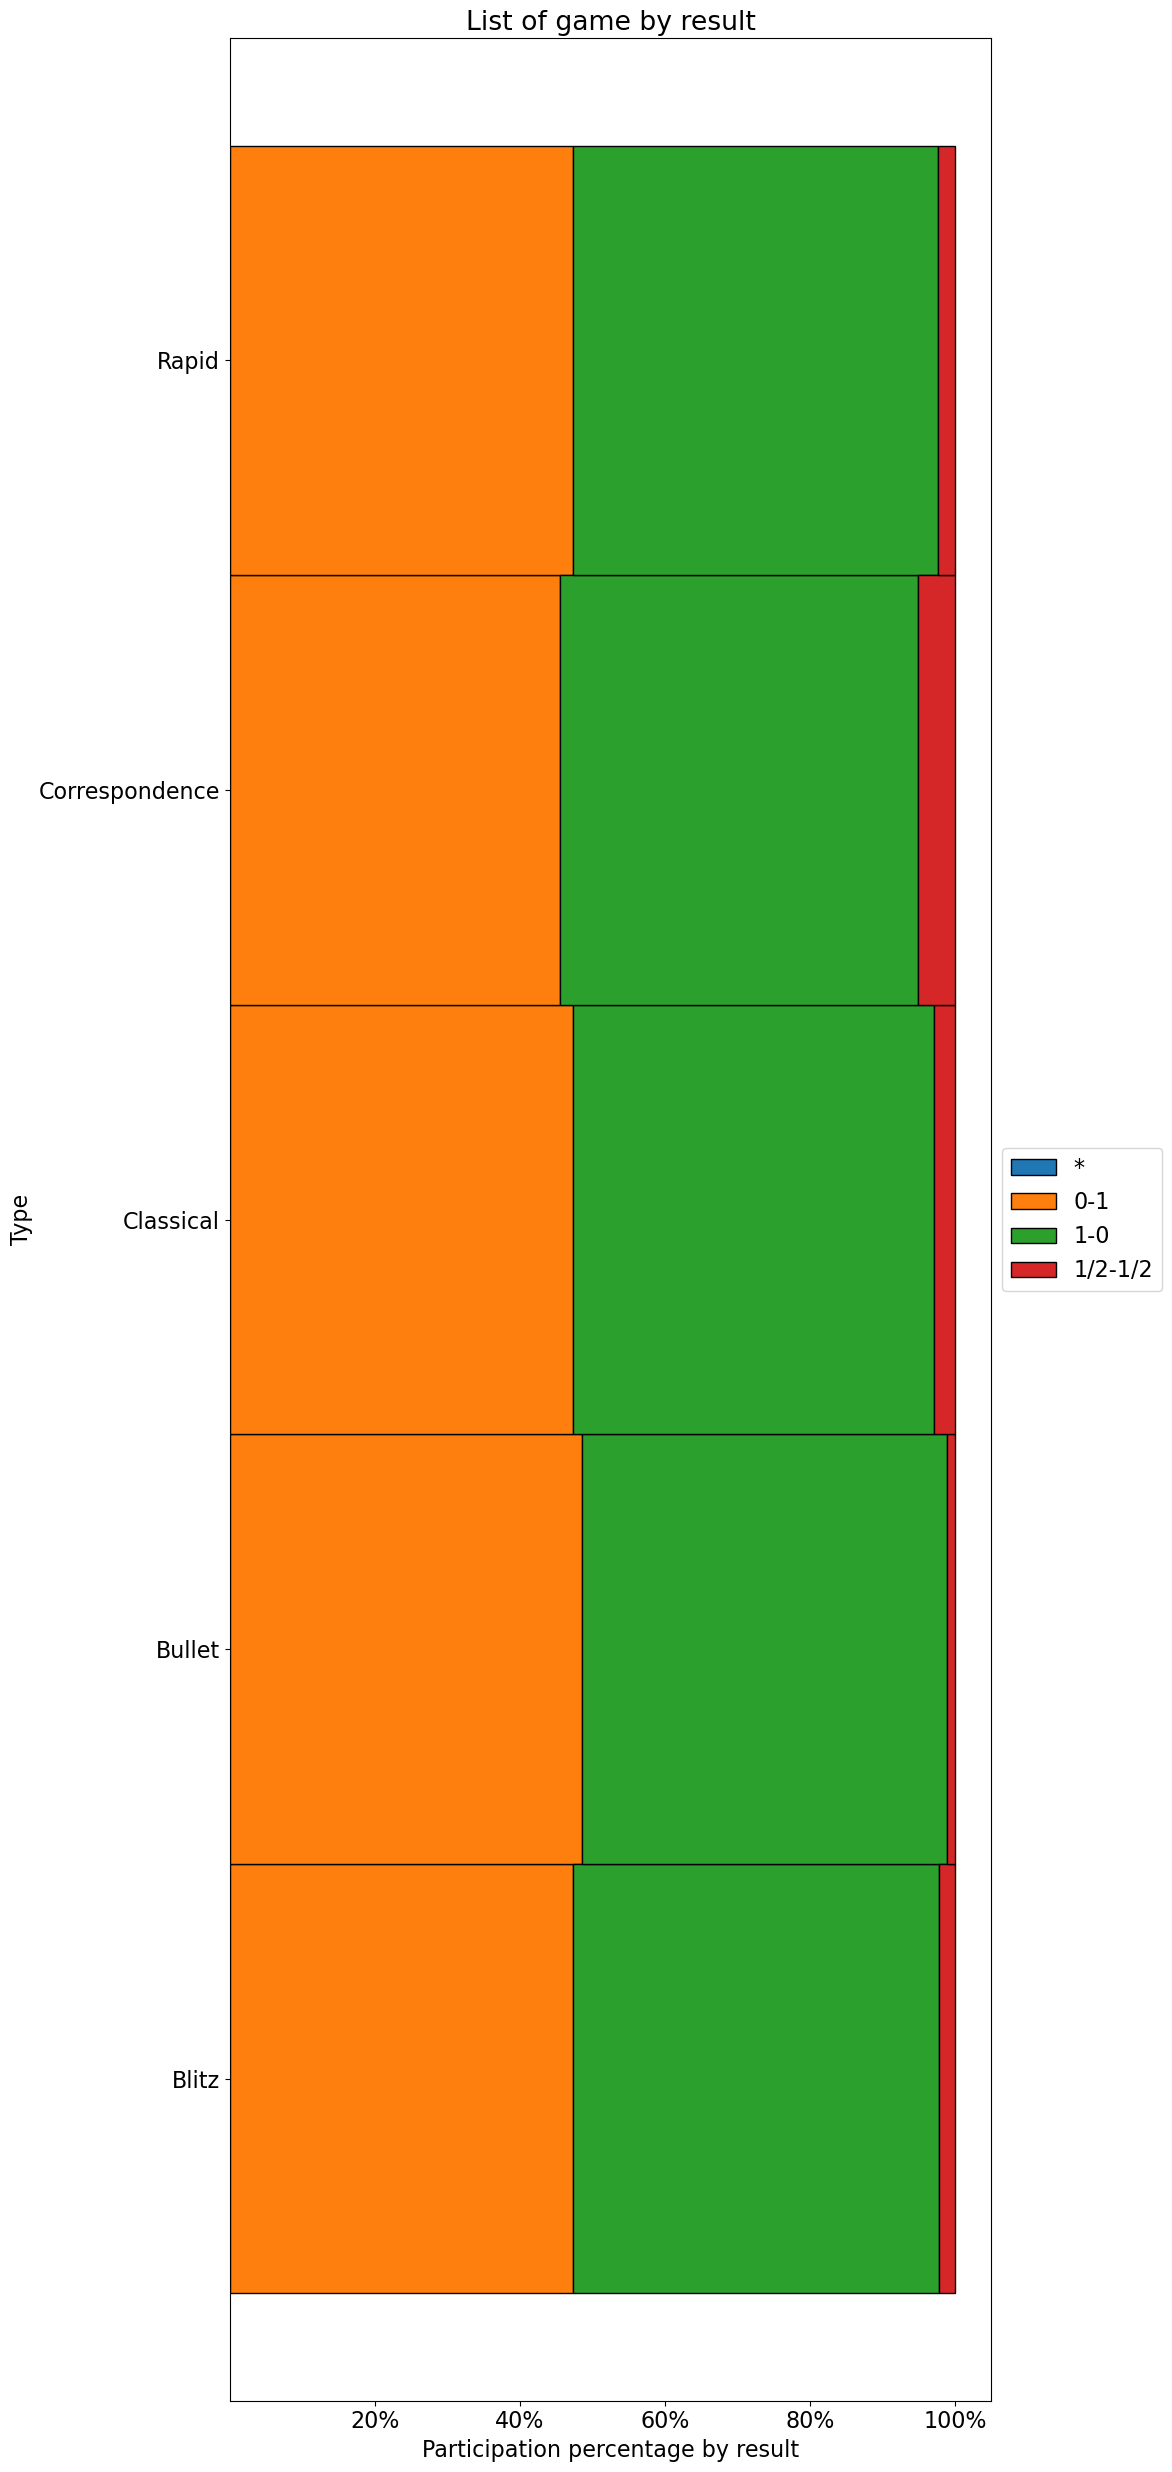

In [9]:
game_by_result_df = df.groupBy(df.Game_type, df.Result).count().toPandas()

results = game_by_result_df['Result'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = game_by_result_df.groupby(['Game_type', 'Result'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of game by result')
ylabel = plt.ylabel('Type');
xlabel = plt.xlabel('Participation percentage by result');
legend = plt.legend(
    sorted(results), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

# Среднее количество "переворотов" игры в различных типах игры

<AxesSubplot: xlabel='Game_type'>

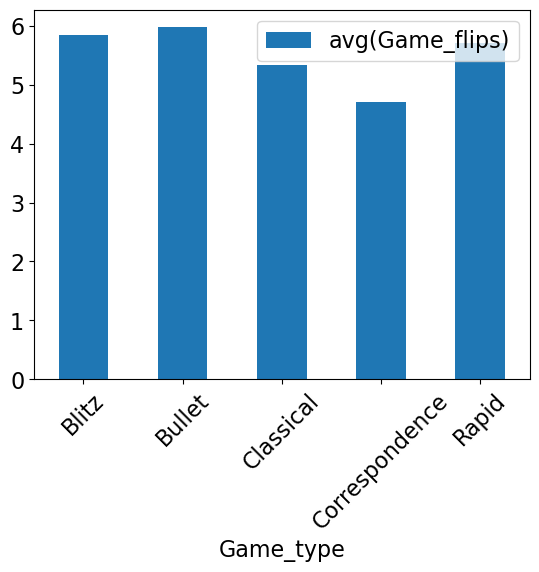

In [10]:
type_count = ['Rapid', 'Correspondence', 'Classical', 'Bullet', 'Blitz']

df.select(df.Game_type, df.Game_flips) \
    .filter(df.Game_type.isin(type_count)) \
    .groupBy(df.Game_type) \
    .avg('Game_flips') \
    .toPandas() \
    .sort_values(by='Game_type') \
    .plot.bar(column="avg(Game_flips)", x='Game_type', rot=45)

# Средний рейтинг игроков, играющих за белых в разных типах игры

<AxesSubplot: ylabel='Game_type'>

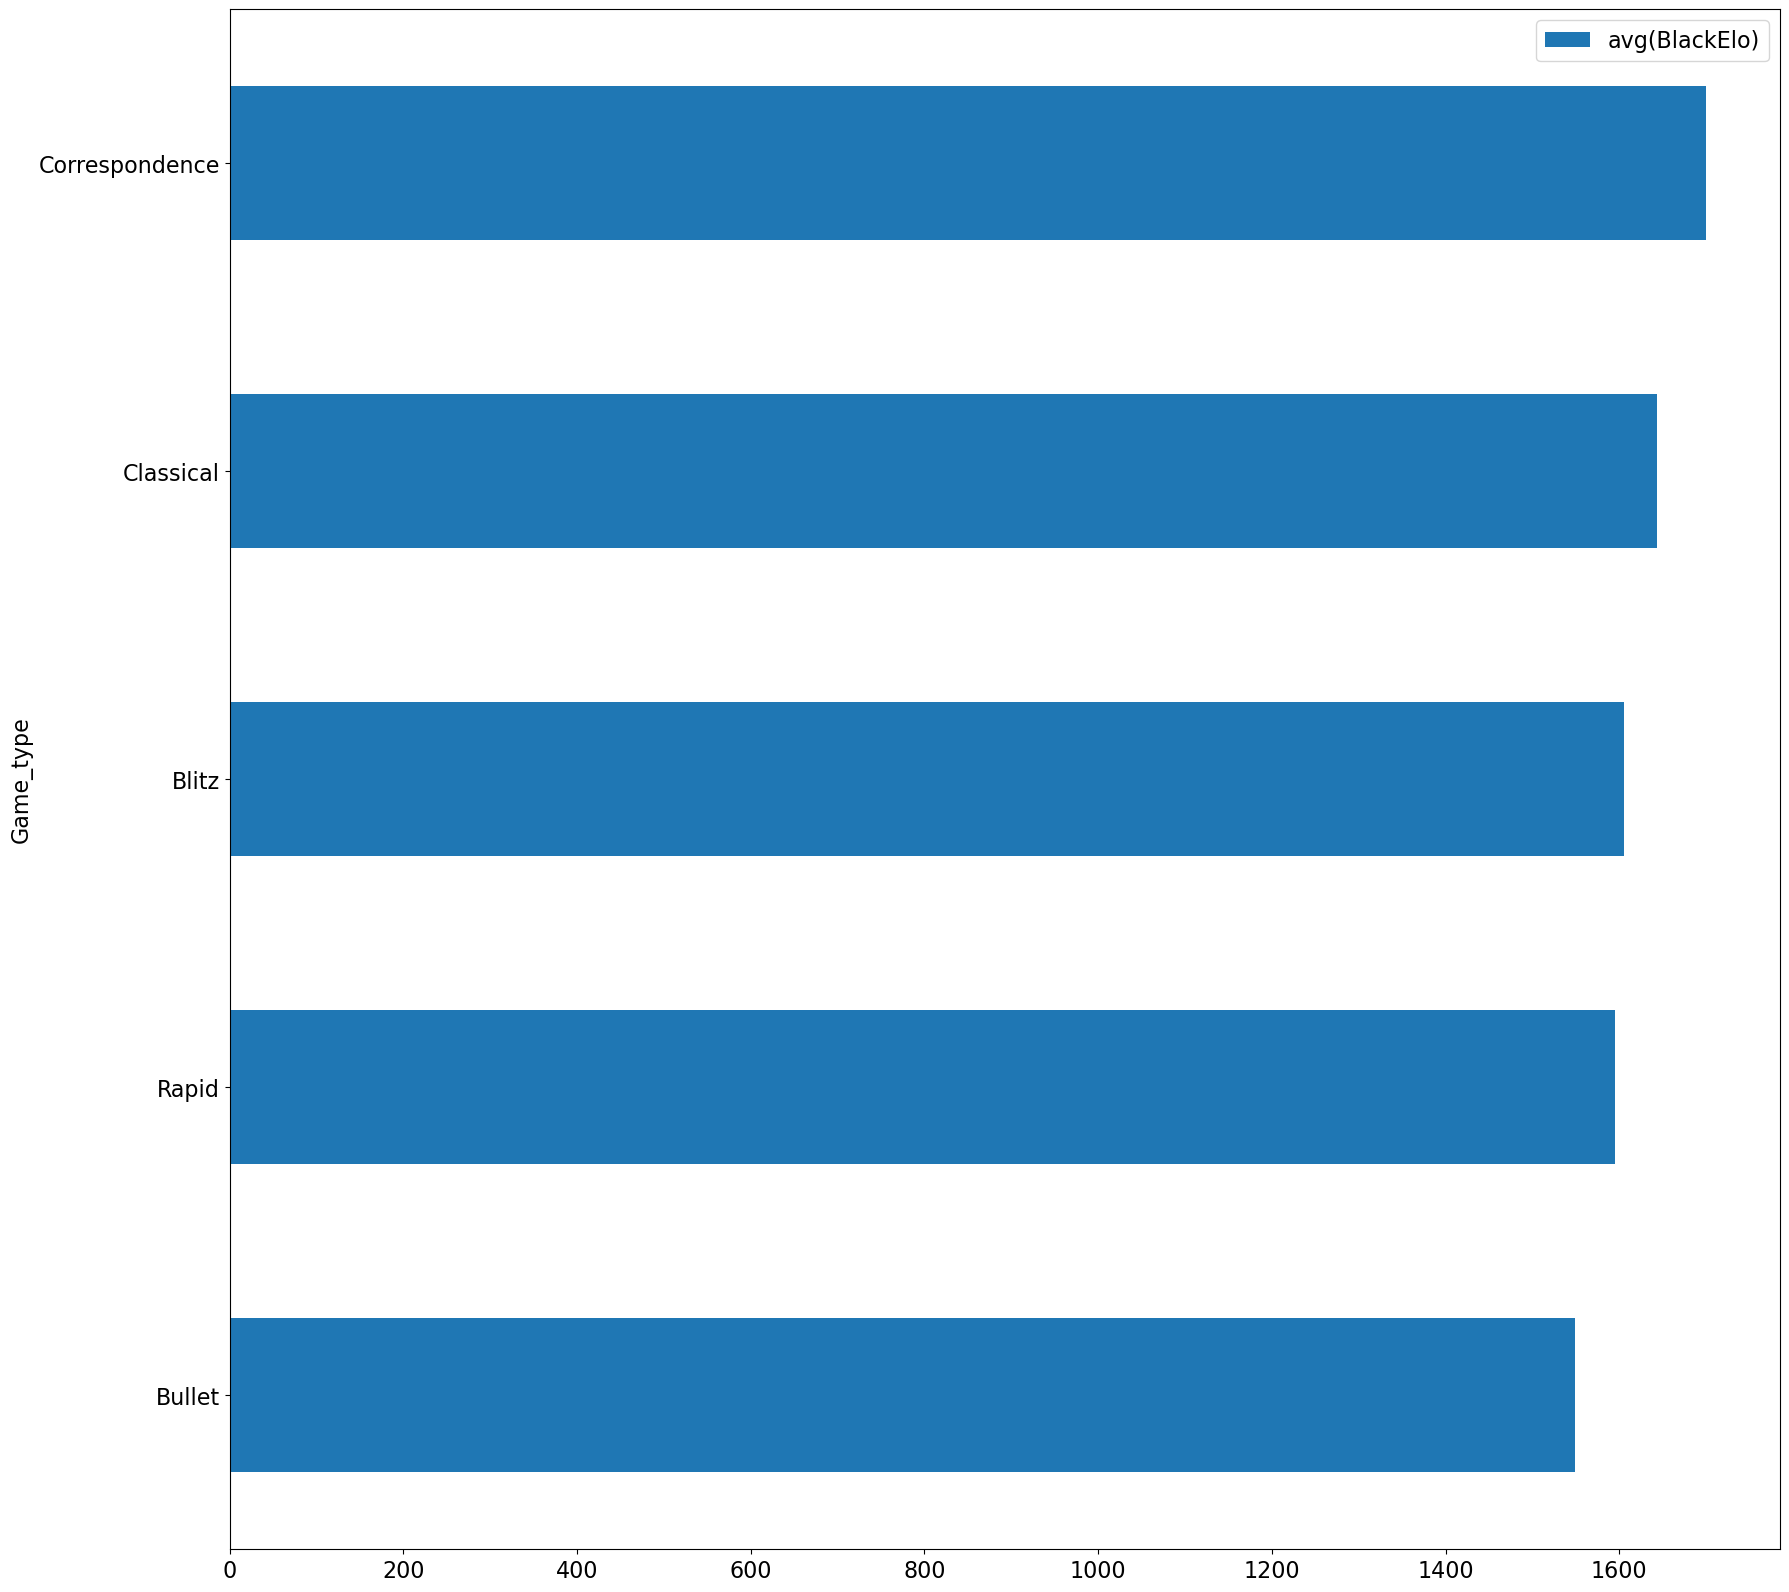

In [11]:
df.select(df.Game_type, df.BlackElo) \
    .groupBy(df.Game_type) \
    .avg('BlackElo') \
    .toPandas() \
    .sort_values(by='avg(BlackElo)') \
    .plot.barh(column="avg(BlackElo)", x='Game_type', figsize=(20,20))

# Средний рейтинг игроков, играющих за белых в разных типах игры

<AxesSubplot: ylabel='Game_type'>

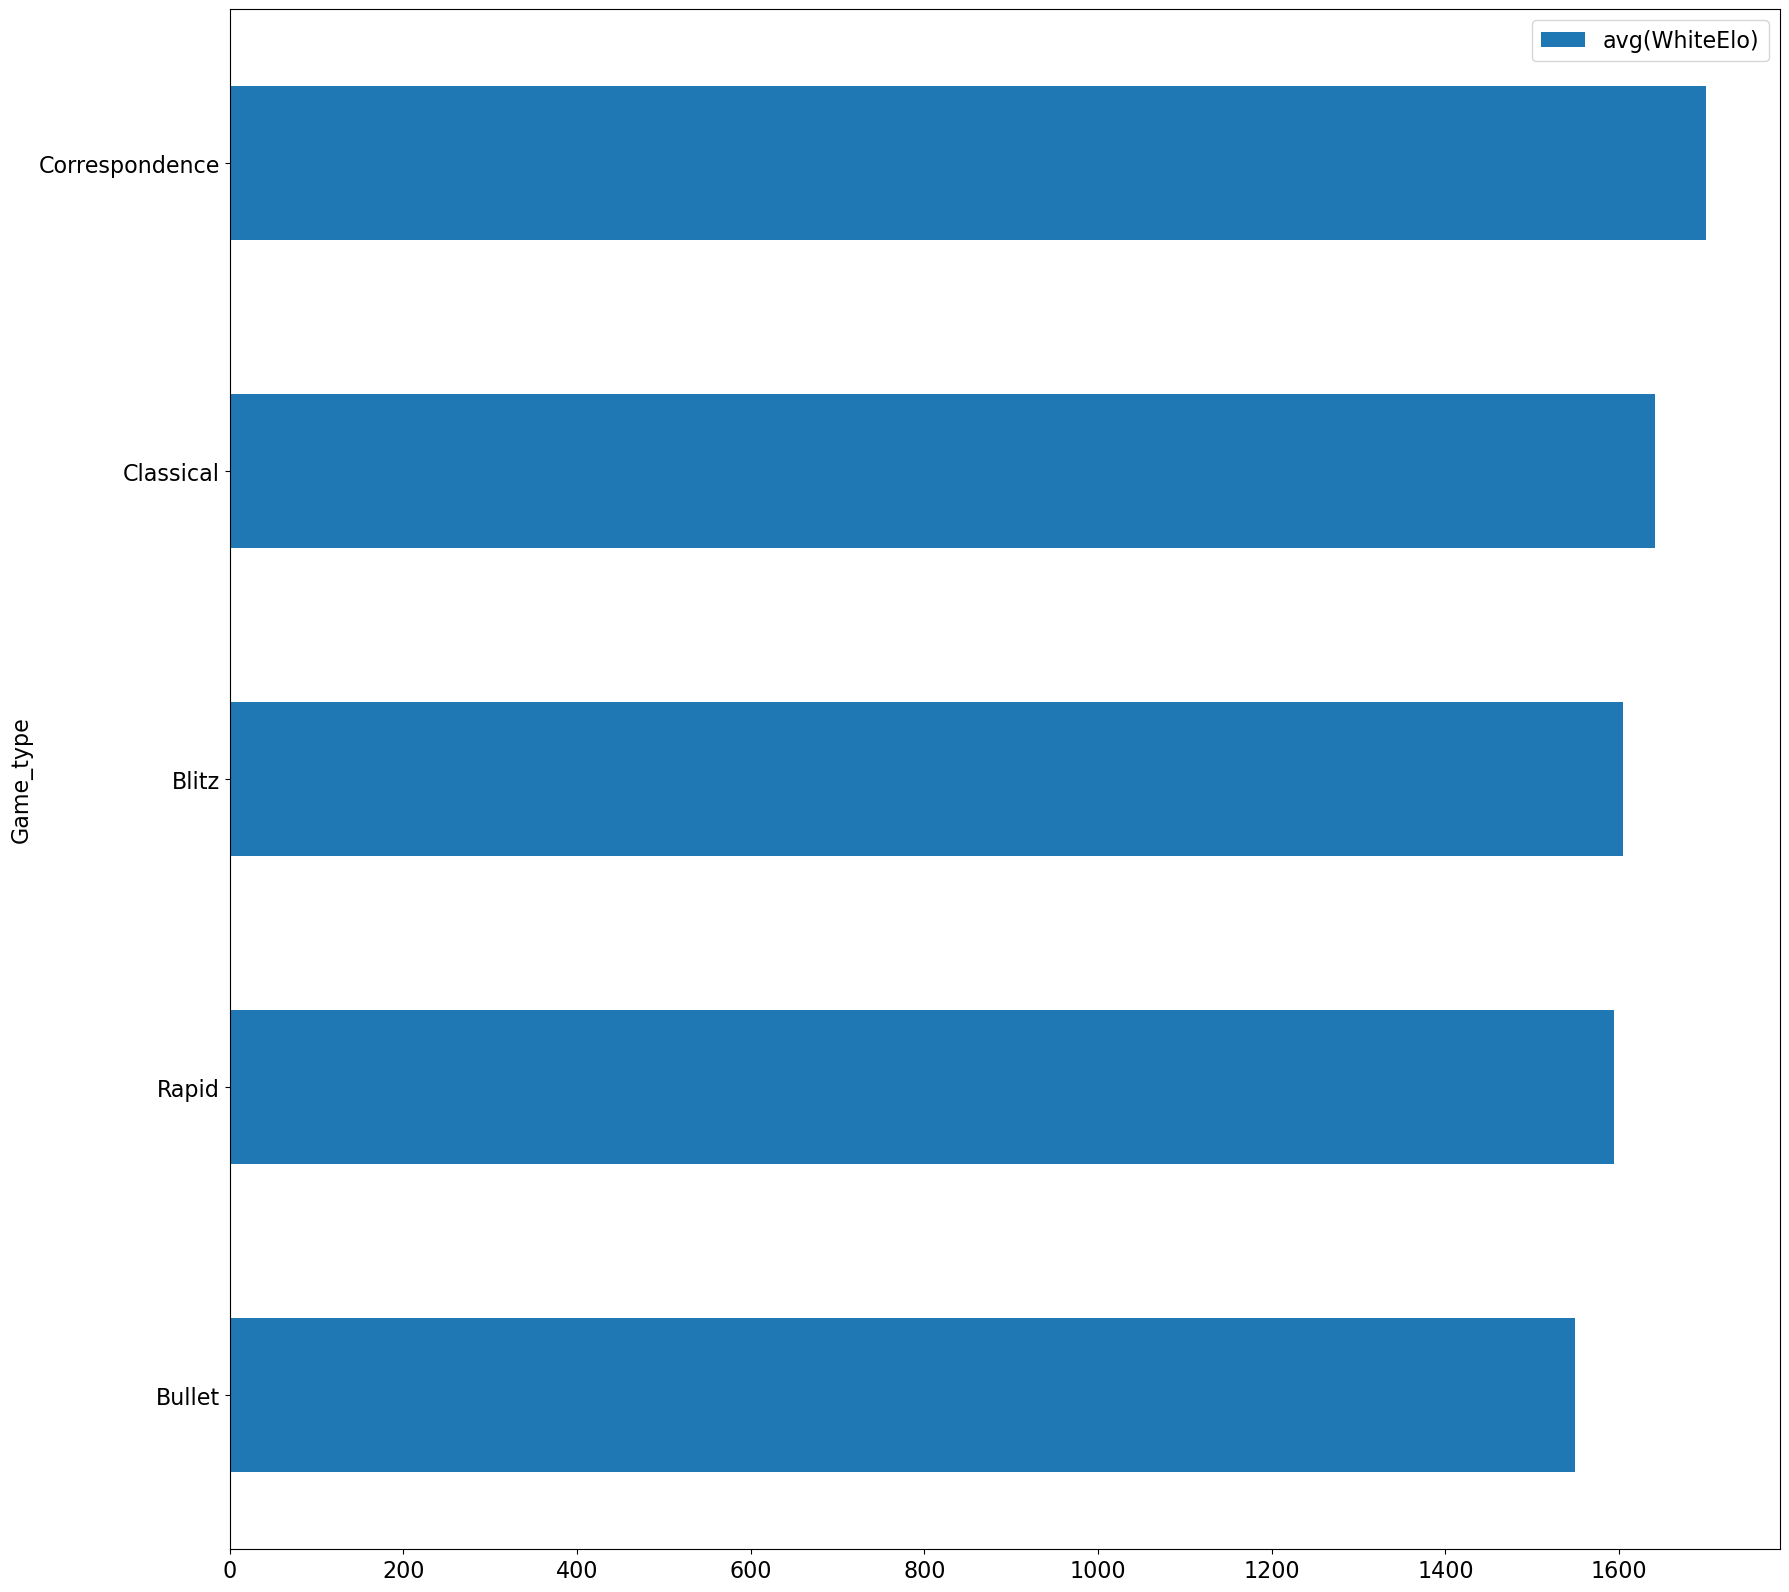

In [12]:
df.select(df.Game_type, df.WhiteElo) \
    .groupBy(df.Game_type) \
    .avg('WhiteElo') \
    .toPandas() \
    .sort_values(by='avg(WhiteElo)') \
    .plot.barh(column="avg(WhiteElo)", x='Game_type', figsize=(20,20))

# Топ 5 дебютов в различных типах игры

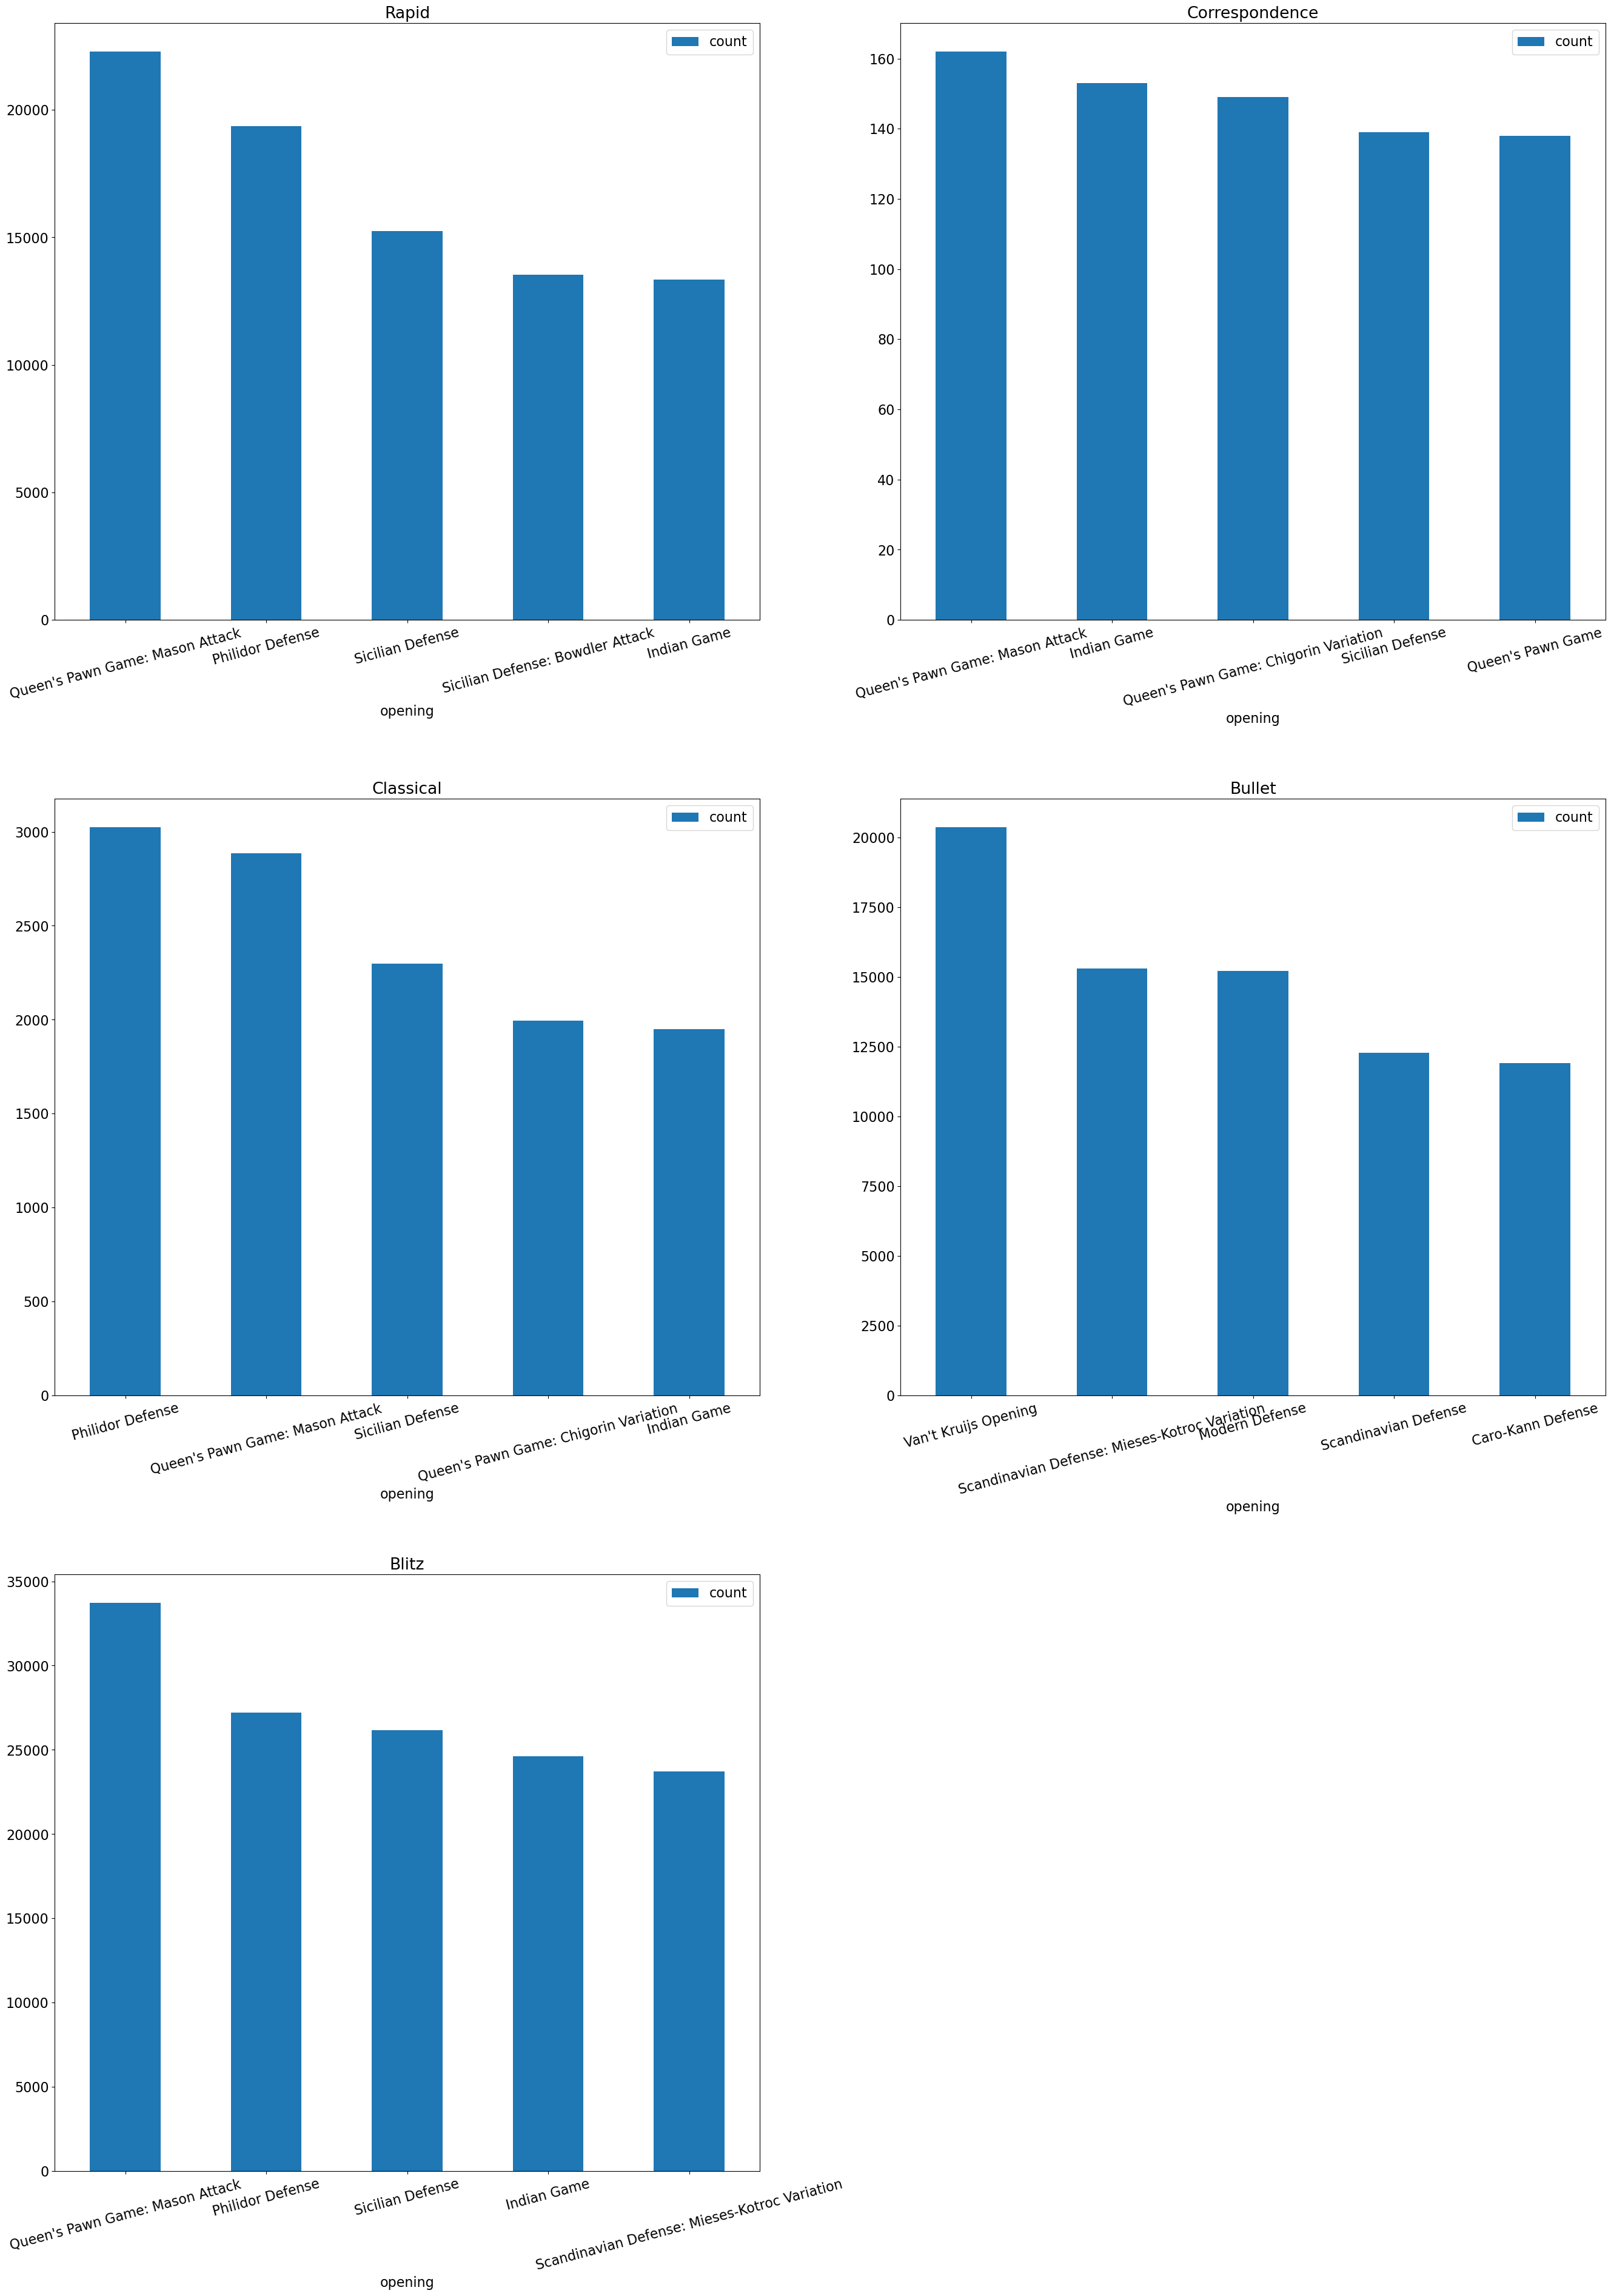

In [13]:
plot_size_x, plot_size_y = 15, 15
figsize_x, figsize_y = plot_size_x * 2 + 3, plot_size_y * 3 + 1
figsize=(figsize_x, figsize_y)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(figsize_x, figsize_y))
types = ['Rapid', 'Correspondence', 'Classical', 'Bullet', 'Blitz']

for i in range(len(types)):
    row_index, col_index = divmod(i, 2)
    top_opening_by_types = df.select(df.Opening, df.Game_type) \
        .filter(df.Game_type == types[i]) \
        .groupBy('opening') \
        .count() \
        .toPandas() \
        .sort_values(by='count', ascending=False) \
        .head(5)
    _ = top_opening_by_types.plot.bar(column="count", x='opening', rot=15, ax = ax[row_index, col_index])
    _ = ax[row_index, col_index].set_title(types[i])

ax[2, 1].set_visible(False)
plt.subplots_adjust(hspace=0.3)

# Среднее количество ходов в трех популярных типах игры

In [14]:
moves_mean = [] 
moves_stddev = []
moves_min = [] 
moves_max = []


for Game_type in highest_games_type_df['Game_type']:
    if Game_type != 'others': 
        describe_values = df.select(df.Total_moves).filter(df.Game_type == Game_type).describe().toPandas()
    else:
        types = highest_games_type_df['Game_type'].tolist()
    moves_mean.append(float(describe_values.loc[1]['Total_moves']))
    moves_stddev.append(float(describe_values.loc[2]['Total_moves']))
    moves_min.append(describe_values.loc[3]['Total_moves'])
    moves_max.append(describe_values.loc[4]['Total_moves'])

highest_games_type_df['mean moves'] = moves_mean
highest_games_type_df['stddev moves'] = moves_stddev
highest_games_type_df['min moves'] = moves_min
highest_games_type_df['max moves'] = moves_max
    
highest_games_type_df

,Game_type,count,percentage,mean moves,stddev moves,min moves,max moves
0,Blitz,1655951,44.277842,61.269262,22.000401,5,123
1,Rapid,883537,23.624559,60.696482,22.608141,5,123
2,Bullet,758876,20.291296,58.465170,17.662703,5,123
0,others,441545,11.806303,58.465170,17.662703,5,123


# Статистика по ходам в различных типах игры

In [15]:
game_type_moves_statistic_df = []
all_types = df.select(df.Game_type) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

for all_type in all_types:
    stat_dict = {'Game_type': all_type}
    game_type_moves__df = df.select(df.Total_moves).filter(df.Game_type==all_type)
    stats = game_type_moves__df.select(
        percentile_approx(df.Total_moves,[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min('Total_moves').alias('min'),
        max('Total_moves').alias('max'),
        mean('Total_moves').alias('mean'),
        stddev('Total_moves').alias('stddev'),
    ).collect()[0]
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    game_type_moves_statistic_df.append(stat_dict)
    
game_type_moves_statistic_df = pd.DataFrame(game_type_moves_statistic_df)
game_type_moves_statistic_df

,Game_type,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,Bullet,45,56,69,89,5,123,58.465170,17.662703
1,Blitz,45,58,75,104,5,123,61.269262,22.000401
2,Classical,45,58,75,105,5,123,61.233343,22.487391
3,Rapid,44,58,75,105,5,123,60.696482,22.608141
4,Correspondence,39,55,74,105,5,123,57.622193,24.886554
